# Anomaly Detection Notebook
### Date Started:   12 June 2024
### Latest Update: 

## Chapter 3: Robust Covariance
#### Tries out Elliptic Envelope method with three different contamination parameters 

## 1. Split Dataframe into Train and Test 

In [2]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope


from sklearn.metrics import precision_score, recall_score, f1_score,  average_precision_score, confusion_matrix

import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn

In [3]:
# Import
data_directory = "../01-Data/"
file_name = "thyroid.csv"      # Cleaned data exported from Week 1 notebook 
dfThyroid = pd.read_csv(data_directory  + file_name)

# Check
pd.DataFrame.info(dfThyroid)
dfThyroid

In [4]:
# Drop first column
dfThyroid = dfThyroid.drop(dfThyroid.columns[0], axis=1) 
dfThyroid

,0,0.1,1,2,3,4,5
0,0.0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066
1,0.0,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770
2,0.0,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590
3,0.0,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066
4,0.0,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541
...,...,...,...,...,...,...,...
3767,0.0,0.817204,0.000113,0.190702,0.287383,0.413146,0.188525
3768,0.0,0.430108,0.002453,0.232448,0.287383,0.446009,0.175410
3769,0.0,0.935484,0.024528,0.160342,0.282710,0.375587,0.200000
3770,0.0,0.677419,0.001472,0.190702,0.242991,0.323944,0.195082


In [5]:
# Convert 0 and 1 in 1st column as float to integer
# Commented line doesn't work
# dfThyroid.iloc[:, 0] = dfThyroid.iloc[:, 0].astype(int)
dfThyroid["0"] = dfThyroid["0"].astype(int)

In [6]:
pd.DataFrame.info(dfThyroid)
pd.DataFrame.describe(dfThyroid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3772 non-null   int64  
 1   0.1     3772 non-null   float64
 2   1       3772 non-null   float64
 3   2       3772 non-null   float64
 4   3       3772 non-null   float64
 5   4       3772 non-null   float64
 6   5       3772 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 206.4 KB


,0,0.1,1,2,3,4,5
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,0.024655,0.543121,0.008983,0.186826,0.248332,0.376941,0.177301
std,0.155093,0.203790,0.043978,0.070405,0.080579,0.087382,0.054907
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.376344,0.001132,0.156546,0.203271,0.328638,0.149180
50%,0.000000,0.569892,0.003019,0.190702,0.241822,0.375587,0.173770
75%,0.000000,0.709677,0.004528,0.213472,0.282710,0.413146,0.196721
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Splits the dataset into two after randomisation (not suitable for ts)
train_dfThyroid, test_dfThyroid = train_test_split(dfThyroid, test_size=0.2, random_state=42)

In [8]:
# Check 
print("Training dataset: \n")
pd.DataFrame.info(train_dfThyroid)
pd.DataFrame.describe(train_dfThyroid)

Training dataset: 

<class 'pandas.core.frame.DataFrame'>
Index: 3017 entries, 2661 to 3174
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3017 non-null   int64  
 1   0.1     3017 non-null   float64
 2   1       3017 non-null   float64
 3   2       3017 non-null   float64
 4   3       3017 non-null   float64
 5   4       3017 non-null   float64
 6   5       3017 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 188.6 KB


,0,0.1,1,2,3,4,5
count,3017.000000,3017.000000,3017.000000,3017.000000,3017.000000,3017.000000,3017.000000
mean,0.024528,0.543888,0.009024,0.187627,0.249195,0.377464,0.177772
std,0.154706,0.204102,0.044331,0.071170,0.081646,0.087264,0.056181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.376344,0.001132,0.156546,0.203271,0.328638,0.149180
50%,0.000000,0.569892,0.002830,0.190702,0.240654,0.375587,0.173770
75%,0.000000,0.709677,0.004528,0.213472,0.282710,0.413146,0.196721
max,1.000000,1.000000,0.901887,1.000000,1.000000,0.896714,1.000000


In [9]:
print("\n")
pd.DataFrame.info(test_dfThyroid)
pd.DataFrame.describe(test_dfThyroid)



<class 'pandas.core.frame.DataFrame'>
Index: 755 entries, 270 to 543
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       755 non-null    int64  
 1   0.1     755 non-null    float64
 2   1       755 non-null    float64
 3   2       755 non-null    float64
 4   3       755 non-null    float64
 5   4       755 non-null    float64
 6   5       755 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 47.2 KB


,0,0.1,1,2,3,4,5
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,0.025166,0.540056,0.008821,0.183626,0.244886,0.374853,0.175417
std,0.156732,0.202645,0.042565,0.067215,0.076120,0.087880,0.049478
min,0.000000,0.000000,0.000000,0.004744,0.006542,0.056338,0.005574
25%,0.000000,0.376344,0.001132,0.147059,0.200935,0.323944,0.149180
50%,0.000000,0.569892,0.003208,0.190702,0.242991,0.375587,0.173770
75%,0.000000,0.698925,0.004717,0.203985,0.281542,0.399061,0.196721
max,1.000000,1.000000,1.000000,0.668880,0.605140,1.000000,0.508197


## 2. Quantify the number of outliers

In [10]:
# Count the number of outliers
outlier_count = dfThyroid[dfThyroid.iloc[:, 0] == 1].shape[0]

print(f"Number of outliers in entire dataset: {outlier_count}")

Number of outliers in entire dataset: 93


In [11]:
# Count the number of outliers in Train and Test
train_outlier_count = train_dfThyroid[train_dfThyroid.iloc[:, 0] == 1].shape[0]
print(f"Number of outliers in training dataset: {train_outlier_count}")

test_outlier_count = test_dfThyroid[test_dfThyroid.iloc[:, 0] == 1].shape[0]
print(f"Number of outliers in training dataset: {test_outlier_count}")

Number of outliers in training dataset: 74
Number of outliers in training dataset: 19


## 3. Separate out samples corresponding to the inliers

In [12]:
# Separate training inliers and outliers records 
train_inliers = train_dfThyroid[train_dfThyroid.iloc[:, 0] == 0]
train_outliers = train_dfThyroid[train_dfThyroid.iloc[:, 0] == 1]

outliers_fraction = train_outliers.shape[0] / (train_inliers.shape[0] + train_outliers.shape[0])

# Display the shape of inliers and outliers DataFrames
print(f"Number of training inliers: {train_inliers.shape[0]}")
print(f"Number of training outliers: {train_outliers.shape[0]}")
print(f"Outlier fraction is: {outliers_fraction}")

Number of training inliers: 2943
Number of training outliers: 74
Outlier fraction is: 0.024527676499834273


In [13]:
# Separate testing inliers and outliers
test_inliers = test_dfThyroid[test_dfThyroid.iloc[:, 0] == 0]
test_outliers = test_dfThyroid[test_dfThyroid.iloc[:, 0] == 1]

# Display the shape of inliers and outliers DataFrames
print(f"Number of inliers: {test_inliers.shape[0]}")
print(f"Number of outliers: {test_outliers.shape[0]}")

Number of inliers: 736
Number of outliers: 19


## 4. Instantiate three Elliptic Envelope Models

In [14]:
# Instantiate the three Elliptic Envelope objects
ee_1x = EllipticEnvelope(contamination=1 * outliers_fraction)
ee_2x = EllipticEnvelope(contamination=2 * outliers_fraction)
ee_4x = EllipticEnvelope(contamination=4 * outliers_fraction)

# Display the instantiated objects
print("Elliptic Envelope with contamination 1x: ", ee_1x)
print("Elliptic Envelope with contamination 2x: ", ee_2x)
print("Elliptic Envelope with contamination 4x: ", ee_4x)

Elliptic Envelope with contamination 1x:  EllipticEnvelope(contamination=0.024527676499834273)
Elliptic Envelope with contamination 2x:  EllipticEnvelope(contamination=0.049055352999668546)
Elliptic Envelope with contamination 4x:  EllipticEnvelope(contamination=0.09811070599933709)


In [15]:
# Set up df with metrics

# Initialize the DataFrame with the required columns
metrics_df = pd.DataFrame(columns=[
    'Model', 
    'Precision', 
    'Recall', 
    'F1 Score', 
    'Average Precision', 
    'TN', 
    'TP', 
    'FN', 
    'FP'
])

# Display the initialized DataFrame
print(metrics_df)

Empty DataFrame
Columns: [Model, Precision, Recall, F1 Score, Average Precision, TN, TP, FN, FP]
Index: []


## 5. Fit each of the three models

In [16]:
# Drop the target (first) column when assigning X_inliers (target dataset)

X_inliers = train_inliers.iloc[:, 1:]

# Instantiate the three Elliptic Envelope objects
ee_1x = EllipticEnvelope(contamination=1 * outliers_fraction)
ee_2x = EllipticEnvelope(contamination=2 * outliers_fraction)
ee_4x = EllipticEnvelope(contamination=4 * outliers_fraction)

# Separate the features from the inliers dataset
X_inliers = train_inliers.iloc[:, 1:]  # Assuming the first column is the label

# Fit the Elliptic Envelope models to the inlier data
ee_1x.fit(X_inliers)
ee_2x.fit(X_inliers)
ee_4x.fit(X_inliers)

print("Elliptic Envelope models have been fitted successfully.")

Elliptic Envelope models have been fitted successfully.


## 6. Evaluate on the Test Features 

In [17]:
# Separate the test features and labels
X_test = test_dfThyroid.iloc[:, 1:]
y_test = test_dfThyroid.iloc[:, 0]

In [18]:
# List of models
models = [
    ('EllEnv 1xOutliersFrn', ee_1x),
    ('EllEnv 2xOutliersFrn', ee_2x),
    ('EllEnv 4xOutliersFrn', ee_4x)
]

exit(0)

In [19]:

# Evaluate each model
for model_name, model in models:
    # Predict using the fitted model
    y_pred = model.predict(X_test)
    
    # Map predictions to binary values (inliers = 1, outliers = -1)
    y_pred = [1 if x == 1 else 0 for x in y_pred]

    # Calculate classification metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Append metrics to the DataFrame

    # Create a DataFrame with the new row
    new_row = pd.DataFrame([{
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Average Precision': avg_precision,
        'TN': tn,
        'TP': tp,
        'FN': fn,
        'FP': fp
    }])

    # Append the new row to the metrics DataFrame
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Display the metrics DataFrame
print(metrics_df)

# Copy to a separate dataframe
dfMetrics_ElliptEnv = metrics_df
print(dfMetrics_ElliptEnv)

                  Model  Precision    Recall  F1 Score  Average Precision  TN  \
0  EllEnv 1xOutliersFrn   0.005540  0.210526  0.010796           0.021034  18   
1  EllEnv 2xOutliersFrn   0.001418  0.052632  0.002762           0.023916  32   
2  EllEnv 4xOutliersFrn   0.001502  0.052632  0.002920           0.023920  71   

  TP  FN   FP  
0  4  15  718  
1  1  18  704  
2  1  18  665  
                  Model  Precision    Recall  F1 Score  Average Precision  TN  \
0  EllEnv 1xOutliersFrn   0.005540  0.210526  0.010796           0.021034  18   
1  EllEnv 2xOutliersFrn   0.001418  0.052632  0.002762           0.023916  32   
2  EllEnv 4xOutliersFrn   0.001502  0.052632  0.002920           0.023920  71   

  TP  FN   FP  
0  4  15  718  
1  1  18  704  
2  1  18  665  


/tmp/ipykernel_11737/213577345.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


## 7. Inspect Metrics and Compare Performance 

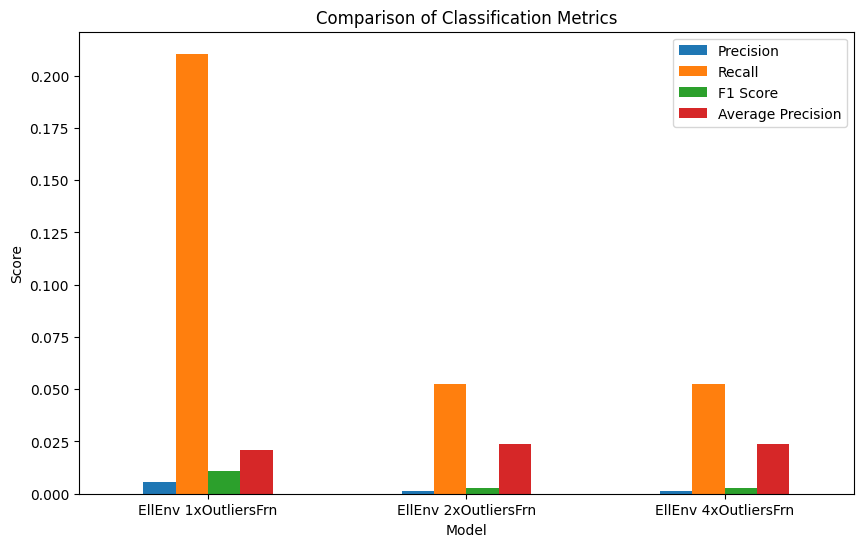

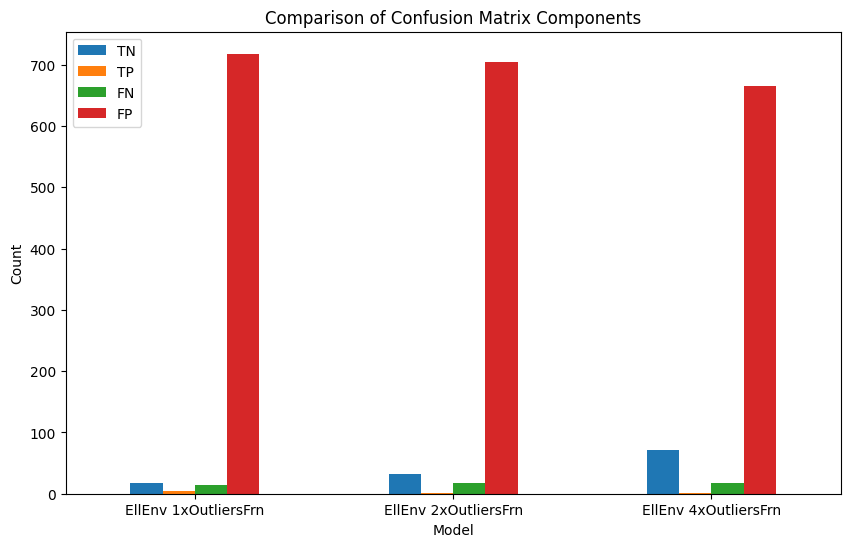

In [20]:
# Plot Precision, Recall, and F1 Score
metrics_df.set_index('Model')[['Precision', 'Recall', 'F1 Score', 'Average Precision']].plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Classification Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

# Plot confusion matrix components (TN, TP, FN, FP)
metrics_df.set_index('Model')[['TN', 'TP', 'FN', 'FP']].plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Confusion Matrix Components')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()
